<b>Проект:</b> Исследование поведения пользователей сервиса аренды самокатов, анализ тарифов и проверка гипотез по увеличению выручки.

<b>Цель проекта:</b> проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.  

<b>Описание данных:</b>  
Для проекта предоставлены данные популярного сервиса аренды самокатов о некоторых пользователях из нескольких городов, а также об их поездках.   
Чтобы совершать поездки по городу, пользователи сервиса пользуются мобильным приложением. Сервисом можно пользоваться:  
•	без подписки   
•	с подпиской Ultra   й Ultra

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import sqrt
from scipy.stats import binom
from math import factorial


# Загрузка данных

# Предобработка данных

Загрузим данные и проанализируем их.

In [3]:
users_go

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


In [4]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
users_go.duplicated().sum()

31

In [6]:
users_go = users_go.drop_duplicates().reset_index(drop=True)

В users_go пропущенные значения отсутствуют, но были обнаружены дубликаты и удалены. Типы данных соответствуют данным.

In [7]:
rides_go

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


In [8]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [9]:
rides_go['date'] = pd.to_datetime(rides_go['date'])

In [10]:
rides_go.duplicated().sum()

0

In [11]:
rides_go['month'] = pd.DatetimeIndex(rides_go['date']).month

В rides_go пропущенные значения и дубликаты отсутствуют. Столбец 'date' приведен к необходимому типу datetime, другие типы данных соответствуют значениям.
создан новый столбец с номером месяца.

In [12]:
subscriptions_go

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [13]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


В subscriptions_go некорректных данных не обнаружено.

# Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:



## Частота встречаемости городов.

In [14]:
users_go.groupby('city')['user_id'].count().sort_values(ascending=False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: user_id, dtype: int64

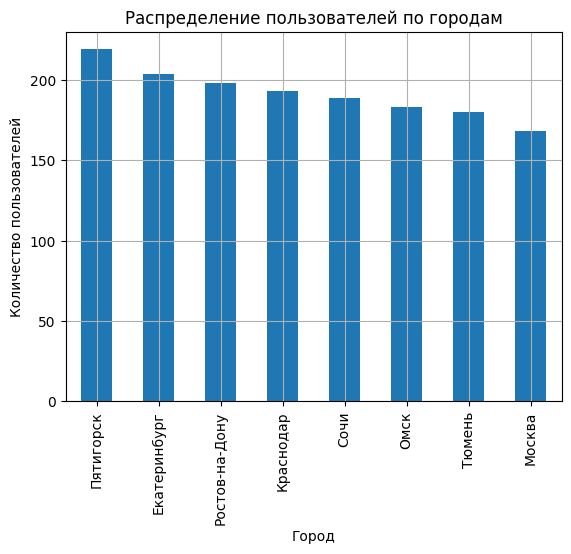

In [15]:
users_go.groupby('city')['user_id'].count().sort_values(ascending=False)\
        .plot(kind='bar',grid='True',title='Распределение пользователей по городам')
plt.xlabel('Город')
plt.ylabel('Количество пользователей');

Количество пользователей во всех предаствленных 8 городах лежит в диапазоне от 168 до 219. Больше всего пользователей в Пятигорске и Екатеринбурге, меньше всего в Москве и Тюмени.

## Соотношение пользователей с подпиской и без подписки.

In [16]:
users_go.groupby(['subscription_type'])['user_id'].count()

subscription_type
free     835
ultra    699
Name: user_id, dtype: int64

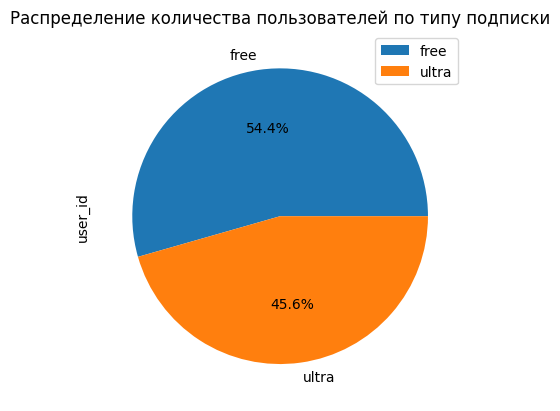

In [17]:
users_go.groupby(['subscription_type']).count()\
.plot(kind='pie', autopct='%.1f%%',y='user_id',title='Распределение количества пользователей по типу подписки');


54,4% составляют пользователи с подпиской  45,6% - без подписки.

## Соотношение по возрасту пользователей.

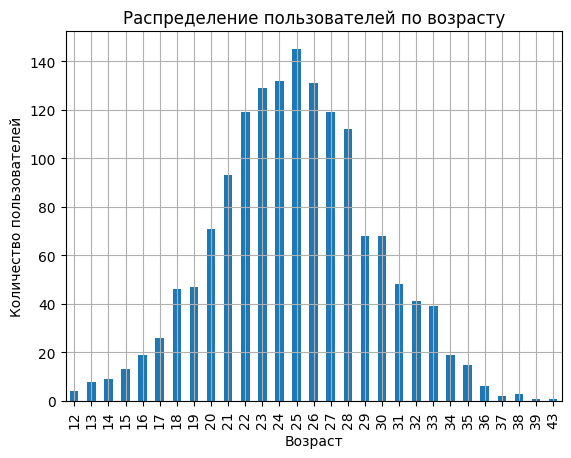

In [18]:
users_go.groupby('age')['user_id'].count().plot(kind='bar',grid='True',title='Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей');

Как мы видим по графику, среди пользователей есть несовершеннолетние пользователи, посчитаем долю поездок, совершенных этими пользователями.

In [19]:
users_go.query('age >= 12 and age <=17')['user_id'].count()/users_go['user_id'].count()

0.051499348109517604

Распределение количества пользователей по возрасту близко к нормальному. Максимальное количество пользователей попадает в интервал от 21 до 28 лет с пиком - 25 лет, и планомерно уменьшается в большую и меньшую сторону до 43 и 12 лет, соответственно.
Также нужно отметить, что среди пользователей присутствует категория несовершеннолетних пользователей в возрасте от 12 до 17 лет. Их доля составляет 5.15% от общего числа поездок, совершенных всеми пользователями.

## Расстояние, которое пользователь преодолел за одну поездку.

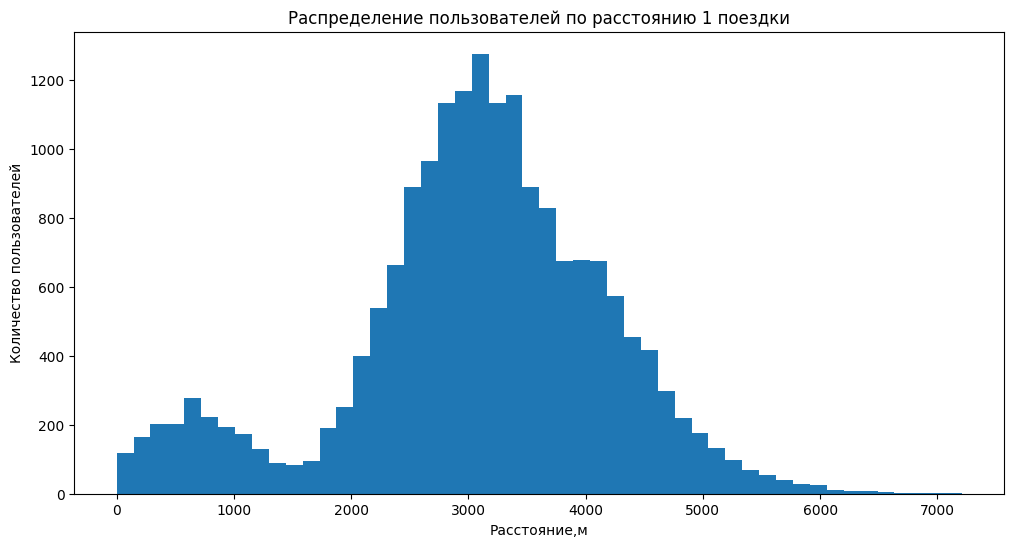

In [20]:
plt.figure(figsize=(12,6))
rides_go['distance'].plot(kind='hist',bins=50,title='Распределение пользователей по расстоянию 1 поездки')
plt.xlabel('Расстояние,м')
plt.ylabel('Количество пользователей');

Большинство пользователей преодолевает за 1 поездку от 2 до 4,5 км. Из них максимальное количество людей - от 2,5 до 3,5 км. Также стоит отметить, что выделяется категория, которая преодолевает небольшое расстояние - до 1,5 км. Скорее всего это люди, которые берут самокаты просто попробовать использование, прокатиться без определенной цели или возможно не разобрались, как пользоваться самокатом, или не понравилось использование. 

## Продолжительность поездок.

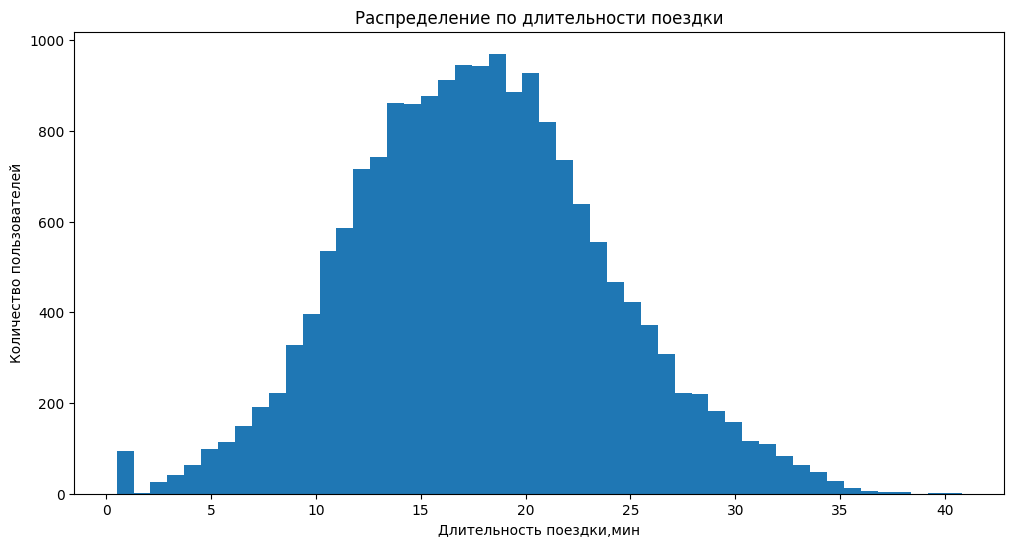

In [21]:
plt.figure(figsize=(12,6))
rides_go['duration'].plot(kind='hist',bins=50,title='Распределение по длительности поездки')
plt.xlabel('Длительность поездки,мин')
plt.ylabel('Количество пользователей');

Проверим также столбец длительности поездок на аномалии и расчитаем их доли в общем объеме.

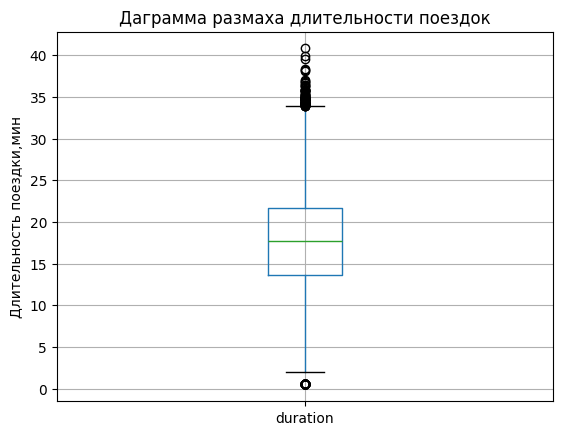

In [22]:
rides_go.boxplot(column='duration')
plt.title('Даграмма размаха длительности поездок')
plt.ylabel('Длительность поездки,мин')
plt.show()

In [23]:
rides_go.query('duration <= 2')['user_id'].count()/users_go['user_id'].count()

0.06192959582790091

In [24]:
rides_go.query('duration > 34')['user_id'].count()/users_go['user_id'].count()

0.04889178617992177

Продолжительность поездок примерно повторяет график распределения расстояния поездок. Основная часть пользователей пользуется самокатами от 9 до 27 минут (с пиком в интервале от 13 до 22 минут).

Также при проверке на аномально большие и маленькие значение обнаружилось, что среди пользователей есть такие, чье время использования самоката составляет примерно 1-2 минуты(доля таких поездок 6.19% от общего количества). Скорее всего это те, кто не смог разобраться, как пользоваться самокатом и отказался от поездки. Также вижно, что изредка пользователи совершают длительные поездки (в интервале 34-43 минуты), что превышает нормальные значения продолжительности поездки(доля таких поездок 4.89% от общего количества).

# Объединение данных и визуализация информации о расстоянии и времени поездок для пользователей с подпиской и без.

Объединим данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуемся методом merge().

In [25]:
all_data = rides_go.merge(users_go, on='user_id',how='left').merge(subscriptions_go, on='subscription_type',how='left')

In [26]:
all_data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [27]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


В созданном датафрейме отсутствуют пропуски. Количество строк в нем равено количеству строк в rides_go, т.к. слияние производилось именно по активным пользователям, которые совершали поездки.   

Создадим ещё два датафрейма из датафрейма, созданного выше:
•	c данными о пользователях без подписки;
•	с данными о пользователях с подпиской


In [28]:
all_data_free = all_data.query('subscription_type == "free"')

In [29]:
all_data_ultra = all_data.query('subscription_type == "ultra"')

Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

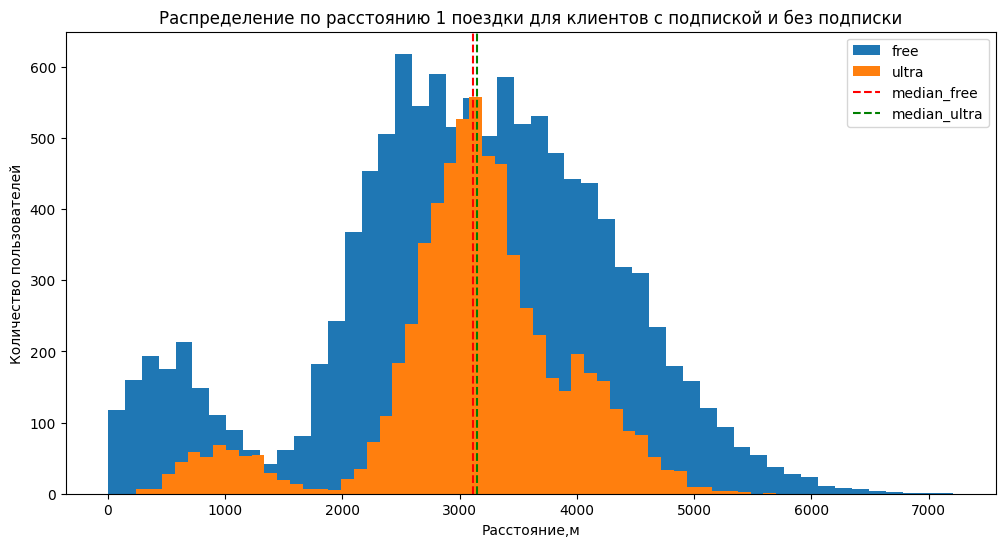

In [30]:
plt.figure(figsize=(12,6))
plt.hist(all_data_free['distance'],bins=50,label='free')
plt.hist(all_data_ultra['distance'],bins=50,label='ultra')
plt.axvline (x=np.nanmedian(all_data_free['distance']), color='red', linestyle='--', label='median_free') 
plt.axvline (x=np.nanmedian(all_data_ultra['distance']), color='green', linestyle='--', label='median_ultra') 
plt.legend()
plt.title('Распределение по расстоянию 1 поездки для клиентов с подпиской и без подписки')
plt.xlabel('Расстояние,м')
plt.ylabel('Количество пользователей');

In [31]:
all_data_free['distance'].median()

3114.648464847295

In [32]:
all_data_ultra['distance'].median()

3148.6372291760854

По графикам видно, что клиенты с подпиской имеют более узкие диапазоны по расстоянию поездок. Короткие поездки до 2 км. И более длительные от 2 до 5-5,5км. с пиком в интервале 2,7-3,3 км (медианное значение - 3148.6 м.) 

Без подписки: короткие поездки составляют расстояние до 1.3 км., а длительные распределены от 1,3км. до 7км., с пиком в интервале примерно 2,2-4,4 км.(медианное значение - 3114.6 м.) 

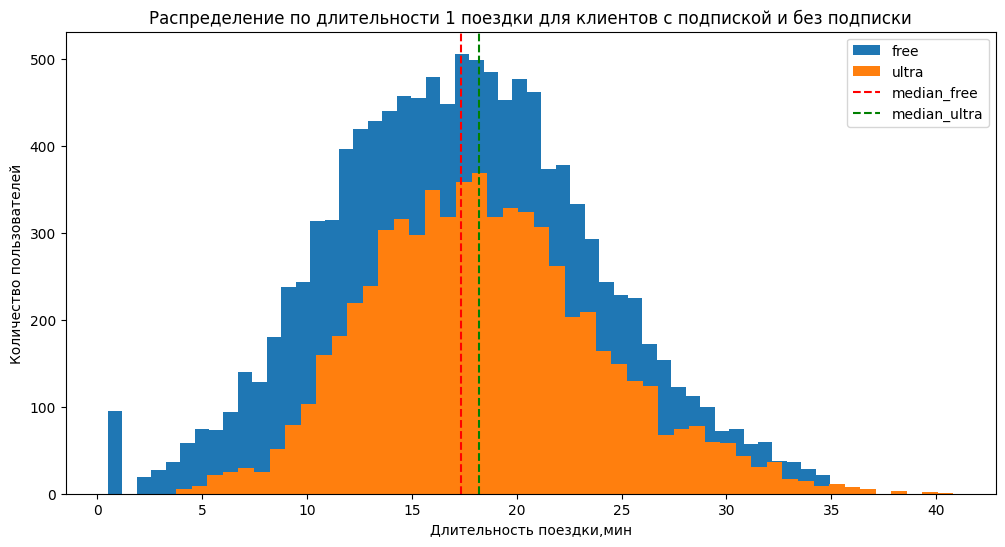

In [33]:
plt.figure(figsize=(12,6))
plt.hist(all_data_free['duration'],bins=50,label='free')
plt.hist(all_data_ultra['duration'],bins=50,label='ultra')
plt.axvline (x=np.nanmedian(all_data_free['duration']), color='red', linestyle='--', label='median_free') 
plt.axvline (x=np.nanmedian(all_data_ultra['duration']), color='green', linestyle='--', label='median_ultra') 
plt.legend()
plt.title('Распределение по длительности 1 поездки для клиентов с подпиской и без подписки')
plt.xlabel('Длительность поездки,мин')
plt.ylabel('Количество пользователей');

In [34]:
all_data_free['duration'].median()

17.326890226082043

In [35]:
all_data_ultra['duration'].median()

18.17815320055055

Длительность поездок напрямую связана с расстоянием поездок. 
У пользователей с подпиской: длительность поездок распределяется от 4 до 40 мин. Большинство поездок составляет от 11 до 25 минут (пик - 11 до 23 минут, медиана - 18,18 мин).  
У пользователей без подписки: как раз выделяется категория, которая использовала самокат в пределах 1 минуты, т.е. новички, которые либо не разобрались, как пользоваться самокатом или отказались от использования после активации. Длительность остальных пользователей этой категории от 2 до 35 минут. Большинство используют самокат 11-27 минуты(максимальное количество - 13-23 минут, также, как и пользователи с подпиской, медианное значение - 17,33 мин.).

# Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными all_data: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округлим до следующего целого числа.

In [36]:
all_data['duration'] = np.ceil(all_data['duration']) 

In [37]:
all_data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26.0,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16.0,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,7.0,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19.0,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,27.0,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,20.0,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,22.0,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,19.0,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,17.0,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [38]:
all_data_agg = all_data.groupby(['user_id','month'],as_index = False)\
.agg({'distance':['sum','count'],'duration':'sum','subscription_fee':'first','start_ride_price':'first','minute_price':'first'})

In [39]:
all_data_agg.columns = ['user_id','month','sum_distance','cnt_rides','sum_duration','subscription_fee','start_ride_price',\
                        'minute_price'] 

In [40]:
all_data_agg


,user_id,month,sum_distance,cnt_rides,sum_duration,subscription_fee,start_ride_price,minute_price
0,1,1,7027.511294,2,42.0,199,0,6
1,1,4,754.159807,1,7.0,199,0,6
2,1,8,6723.470560,2,46.0,199,0,6
3,1,10,5809.911100,2,32.0,199,0,6
4,1,11,7003.499363,3,56.0,199,0,6
...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,0,50,8
11327,1534,8,7622.453034,2,48.0,0,50,8
11328,1534,9,4928.173852,1,23.0,0,50,8
11329,1534,11,13350.015305,4,78.0,0,50,8


Добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 

In [41]:
all_data_agg['revenue'] = all_data_agg['cnt_rides']*all_data_agg['start_ride_price']+all_data_agg['subscription_fee']\
+all_data_agg['sum_duration']*all_data_agg['minute_price']

In [42]:
all_data_agg

,user_id,month,sum_distance,cnt_rides,sum_duration,subscription_fee,start_ride_price,minute_price,revenue
0,1,1,7027.511294,2,42.0,199,0,6,451.0
1,1,4,754.159807,1,7.0,199,0,6,241.0
2,1,8,6723.470560,2,46.0,199,0,6,475.0
3,1,10,5809.911100,2,32.0,199,0,6,391.0
4,1,11,7003.499363,3,56.0,199,0,6,535.0
...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,0,50,8,308.0
11327,1534,8,7622.453034,2,48.0,0,50,8,484.0
11328,1534,9,4928.173852,1,23.0,0,50,8,234.0
11329,1534,11,13350.015305,4,78.0,0,50,8,824.0


# Проверка гипотез

Проверим несколько гипотез, которые помогут принять решение о проведении акций для увеличения количества пользователей с подпиской.


## Первая гипотеза

Проверим, тратят ли пользователи с подпиской больше времени на поездки. Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 
Для это рассчитаем количество пользователей, среднее, медианное значение продолжительности поездок и проведем статистический тест для каждой категории: без подписки и с подпиской.


In [43]:
all_data_free['user_id'].count()

11568

In [44]:
all_data_free['duration'].mean()

17.39090929866399

In [45]:
all_data_free['duration'].median()

17.326890226082043

In [46]:
all_data_ultra['user_id'].count()

6500

In [47]:
all_data_ultra['duration'].mean()

18.54198516280583

In [48]:
all_data_ultra['duration'].median()

18.17815320055055

Средние и медианные значения в обоих категориях примерно одинаковые, что говорит о том, что в данных нет больших выбросов (это нам подтверждали и ранее построенные графики).

Проверим одностороннюю гипотезу, что среднее значение длительности поездок выборки пользователей без подписки меньше среднего пользователей с подпиской. 
Нулевая гипотеза: средние значения длительности поездок пользователей с подпиской и без подписки равны.
Альтернативная гипотеза: среднее значение длительности поездок выборки пользователей без подписки меньше среднего пользователей с подпиской.
Т.к.размеры выборок у нас не равны, параметр equal_var принимает значение False.

In [49]:
alpha = 0.05
results = st.ttest_ind(all_data_free['duration'], all_data_ultra['duration'],equal_var=False,alternative='less')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 


p-значение: 5.675781377128977e-37
Отвергаем нулевую гипотезу


Изменим альтернативную гипотезу: среднее значение длительности поездок выборки пользователей с подпиской меньше среднего пользователей без подписки

In [50]:
alpha = 0.05
results = st.ttest_ind(all_data_free['duration'], all_data_ultra['duration'],equal_var=False,alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


В первом слечае полученное значение p-value значительно меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Данный тест подтверждает сделанный выше расчет: пользователи с подпиской тратят на поездки больше времени.

При второй проверке p-value равен 1, т.е. получается, что траты пользователей без подписки всегда не превышают траты пользователей с подпиской.

## Вторая гипотеза. 



Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим, превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку,это значение. 
Нулевая гипотеза: расстояние, которое проезжают пользователи с подпиской равно 3130 метрам.
Альтернативная гипотеза: расстояние, которое проезжают пользователи с подпиской больше 3130 метров.

In [51]:
all_data_ultra['distance'].mean()

3115.4453880370247

In [52]:
optimal_distance = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    all_data_ultra['distance'], 
    optimal_distance,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 


p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Альтернативная гипотеза: расстояние, которое проезжают пользователи с подпиской меньше 3130 метров.

In [53]:
optimal_distance = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    all_data_ultra['distance'], 
    optimal_distance,
      alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 


p-значение: 0.08046311521502145
Не отвергаем нулевую гипотезу


Получается, что среднее значение расстояния, которое проезжают пользователи с подпиской очень с большой вероятностью оказывается близким к оптимальному значению. Это доказывает и простой расчет среднего, произведенный выше. Т.о., использование самокатов пользователей с подпиской можно считать достаточно оптимальным.

## Третья гипотеза.

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Для этого найдем среднее значение выручки за месяц по пользователям с подпиской и без. А также проведем двусторонний статистический тест. Размеры выборок у нас равны, т.к. оценивается одинаковое количество месяцев,но размер их мал, поэтому equal_var примем False.

In [54]:
free = all_data_agg.query('subscription_fee == 0').groupby('month').agg({'revenue':'mean'})

In [55]:
free.mean()

revenue    328.598067
dtype: float64

In [56]:
ultra = all_data_agg.query('subscription_fee == 199').groupby('month').agg({'revenue':'mean'})

In [57]:
ultra.mean()

revenue    362.669645
dtype: float64

In [58]:
free.merge(ultra, on='month')

,revenue_x,revenue_y
month,,
1,323.083333,369.507692
2,313.527410,351.898305
3,336.715827,360.121212
4,335.620253,367.160428
5,328.150087,368.481481
6,326.220713,361.391960
7,329.249110,367.861538
8,331.178761,360.765625
9,335.701906,364.329577


Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.
Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [59]:
alpha = 0.05
results = st.ttest_ind(ultra['revenue'], free['revenue'],equal_var=False, alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.0841921253203195e-12
Отвергаем нулевую гипотезу


По результатам теста видно, вероятность, что траты пользователей с подпиской и без подписки одинаковы практически нулевая. Т.о., можно сделать вывод, что пользователи с  подпиской тратят больше, чем без нее. Это подтверждает и обычный расчет средних: 363 и 330 рублей, соответственно, т.е. на 10 % больше у пользователей с подпиской.

Если техническая команда сервиса обновит сервера, с которыми взаимодействует мобильное приложение, для того, чтобы количество обращений в техподдержку значимо снизилось и предоставит некоторый файл, содержащий для каждого пользователя данные о количестве обращений до обновления и после него, для проверки гипотезы нам понадобится: 
тест для проверки гипотезы о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python методом scipy.stats.ttest_rel(), аргументы: данные о количестве обращений от каждого пользователя до обновления и после, alternative='greater' (т.е.обращений до обновления больше, чем после).

# Распределения

Построим график биноминального распределения для 1000 листовок (100 необходимых новых пользователей разделим на вероятность получения 1 нового пользователя -0.1) с помощью binom.pmf() из модуля scipy.stats, который помогает получить вероятности биномиального распределения. 

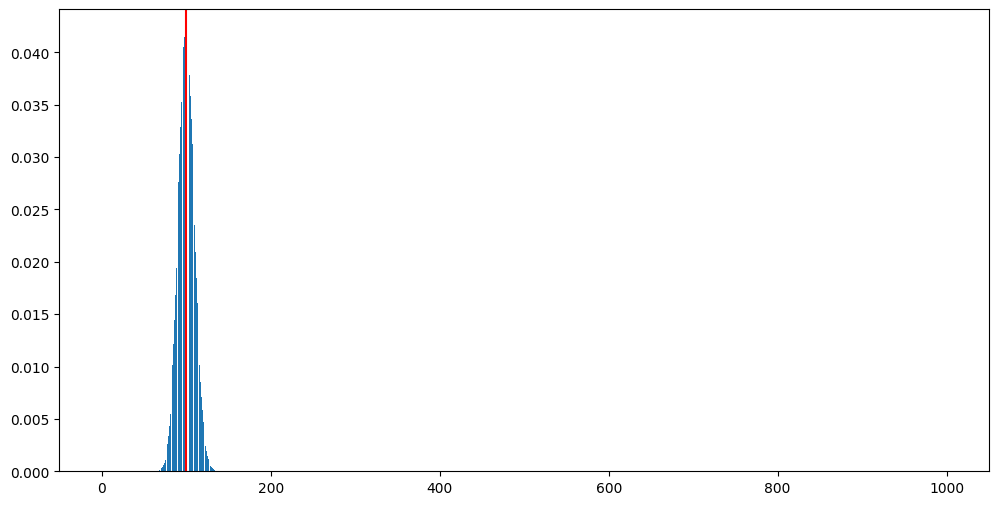

In [60]:
plt.figure(figsize=(12,6))
n = 1000 # количество попыток
p = 0.1 # вероятность успеха
distr = []
for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
plt.bar(range(0, n + 1), distr)
plt.axvline(x=100,color = 'red');

При таком количестве листовок вероятность получить количество пользователей меньше 100 очень велика.
Подберем такое количество листовок, при котором левый хвост графика должен оказаться близким к значению 100 по оси х, чтобы вероятность получения 100 новых пользователей была близка к 95% при проведении акции.

In [61]:
n = 1169
p = 0.1
mu = n*p
sigma = sqrt(n*p*(1-p))
distr = st.norm(mu,sigma)
result = 1-distr.cdf(100)
print(result)


0.9502851068730583


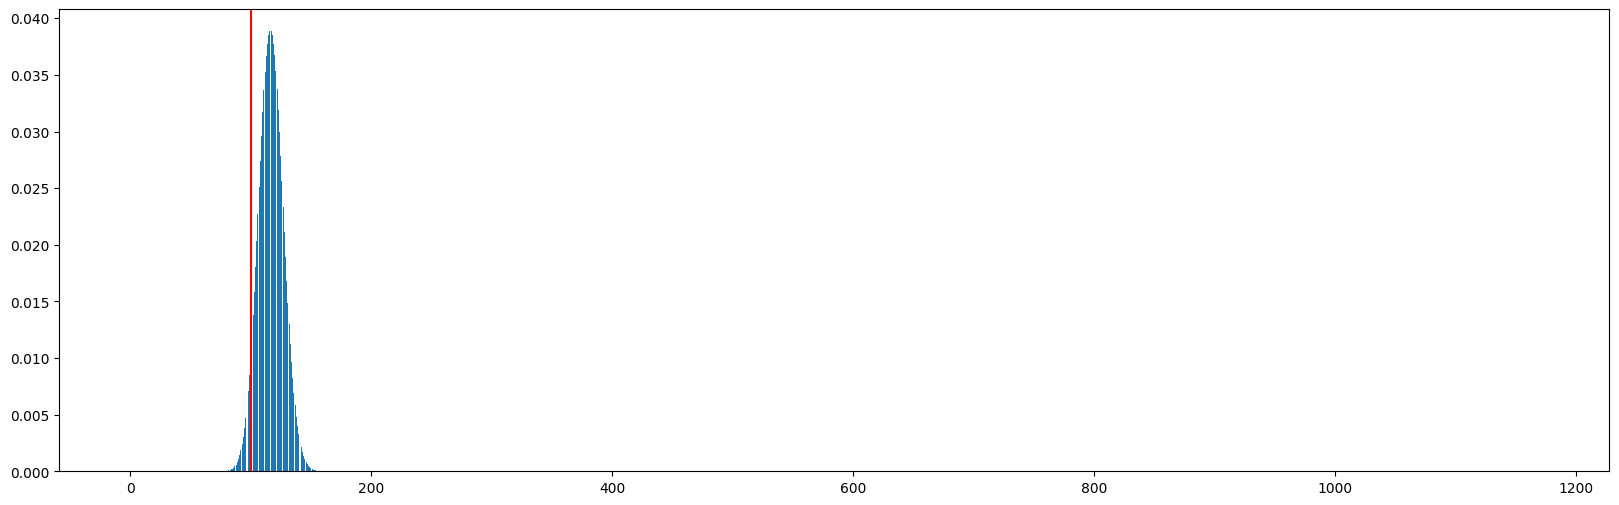

In [62]:
plt.figure(figsize=(20,6))
n = 1169 # количество попыток
p = 0.1 # вероятность успеха
distr = []
for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
plt.bar(range(0, n + 1), distr)
plt.axvline(x=100,color = 'red');

Т.о., чтобы с вероятность 95%,  получить 100 новых подписчиков, нужно раздать примерно 1169 промокодов.



Смоделируем ситуацию: отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. Оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [63]:

n = 1000000
p = 0.4
mu = n*p
sigma = sqrt(n*p*(1-p))
distr = st.norm(mu,sigma)
result = distr.cdf(399500)
print(result)


0.15371708296369768


Вероятность, что уведомление откроют не более 399,5 ты. пользователей составляет 15,37%, т.е. получается, что при таком количестве рассылок вероятность открытия писем большим количеством  пользователей составляет 84,63%.

# ВЫВОДЫ


Для проекта были использованы данные популярного сервиса аренды самокатов о некоторых пользователях из нескольких городов, а также об их поездках. Чтобы совершать поездки по городу, пользователи сервиса пользуются мобильным приложением. Сервисом можно пользоваться без подписки и с подпиской.

Целью проекта было: проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. 

1.	Для начала данные были загружены.

2.	Была проведена предобработка данных: проверены на наличие пропущенных значений, удалены дубликаты, а также данные приведены к нужному формату.

3.	Проведен исследовательский анализ данных. Была описана и визуализирована общая информация о пользователях и поездках по разным параметрам. В результате этого получена следующая информация:
- Количество пользователей во всех представленных 8 городах лежит в диапазоне от 168 до 219 человек. Больше всего пользователей в Пятигорске и Екатеринбурге, меньше всего в Москве и Тюмени.
- 54,4% от общего количества пользователей составляют пользователи с подпиской, 45,6% - без подписки.
-  Распределение количества пользователей по возрасту близко к нормальному. Максимальное количество пользователей попадает в интервал от 21 до 28 лет с пиком - 25 лет, и планомерно уменьшается в большую и меньшую сторону до 43 и 12 лет, соответственно.
Также нужно отметить, что среди пользователей присутствует категория несовершеннолетних пользователей в возрасте от 12 до 17 лет. Их доля составляет 5.15% от общего числа поездок, совершенных всеми пользователями.
- Большинство пользователей преодолевает за 1 поездку от 2 до 4,5 км. Из них максимальное количество людей преодолевает расстояние от 2,5 до 3,5 км. Также стоит отметить, что выделяется категория, которая преодолевает небольшое расстояние - до 1,5 км. Скорее всего это люди, которые берут самокаты, чтобы попробовать их использование, прокатиться без определенной цели или возможно не смогли разобраться, как пользоваться самокатом, или не понравилось использование.
- Продолжительность поездок примерно повторяет график расстояния поездок. Основная часть пользователей пользуется самокатами от 9 до 27 минут (с пиком количества пользователей в интервале от 13 до 22 минут).
Также при проверке на аномально большие и маленькие значение обнаружилось, что среди пользователей есть такие, чье время использования самоката составляет примерно 1-2 минуты(доля таких поездок 6.19% от общего количества). Скорее всего это те, кто не смог разобраться, как пользоваться самокатом и отказался от поездки. Также вижно, что изредка пользователи совершают длительные поездки (в интервале 34-43 минуты), что превышает нормальные значения продолжительности поездки(доля таких поездок 4.89% от общего количества).

4. Далее были объединены данные о пользователях, поездках и подписках в один датафрейм. А также созданы ещё два датафрейма c данными о пользователях без подписки и с подпиской. После этого была визуализирована и проанализирована информация о расстоянии и времени поездок для пользователей обеих категорий и сделаны выводы:
- По графикам видно, что клиенты с подпиской имеют более узкие диапазоны по расстоянию поездок. Короткие поездки до 2 км. И более длительные от 2 до 5-5,5км., с пиком по количеству пользователей в интервале 2,7-3,3 км. 
Без подписки: короткие поездки составляют расстояние до 1,3 км., а длительные распределены от 1,3км. до 7км., с пиком в интервале примерно 2,2-4,4 км.
- Длительность поездок напрямую связана с расстоянием поездок. У пользователей с подпиской: длительность поездок распределяется от 4 до 40 мин. Большинство поездок составляет от 11 до 25 минут (пик по количеству пользователей в интервале от 11 до 23 минут). 
У пользователей без подписки как раз выделяется категория, которая использовала самокат в пределах 1 минуты, т.е. новички, которые либо не разобрались, как пользоваться самокатом, или отказались от использования после активации. Длительность остальных пользователей этой категории от 2 до 35 минут. Большинство используют самокат 11-27 минуты (максимальное количество - 13-23, также, как и пользователи с подпиской).

5. Далее был создан датафрейм с агрегированными данными о поездках и найдено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Продолжительность каждой поездки округлено до следующего целого числа. Добавлен столбец с помесячной выручкой, которую принёс каждый пользователь.

6. После этого было проверено несколько гипотез, для принятия решения о проведении акций для увеличения количества пользователей с подпиской.

Первая гипотеза: пользователи с подпиской тратят больше времени на поездки. Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 
Для это было рассчитано количество пользователей, среднее, медианное значение продолжительности поездок и проведен статистический тест для каждой категории: без подписки и с подпиской.
Средние и медианные значения в обоих категориях оказались примерно одинаковыми, что говорит о том, что в данных нет больших выбросов (это нам подтверждали и ранее построенные графики). Расчетное среднее время на поездки в месяц пользователей с подпиской – 18,54, без подписки – 17,39.
Проверена односторонняя гипотеза, что среднее значение длительности поездок выборки пользователей без подписки меньше среднего пользователей с подпиской. Полученное значение p-value получилось значительно меньше заданного уровня значимости. Данный тест подтверждает сделанный выше расчет: пользователи с подпиской тратят на поездки больше времени.

Вторая гипотеза. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Нужно было проверить, превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, это значение.
Расчет показал, что среднее значение расстояния, которое проезжают пользователи с подпиской очень с большой вероятностью оказывается близким к оптимальному значению. Это доказывает и простой расчет среднего: расчетное среднее расстояние поездки в месяц пользователей с подпиской – 362.67, без подписки – 328.60. Т.о., использование самокатов пользователей с подпиской можно считать достаточно оптимальным.

Третья гипотеза. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
Для этого было найдено среднее значение выручки за месяц по пользователям с подпиской и без, а также проведен двусторонний статистический тест. 
По результатам теста видно: вероятность, что траты пользователей с подпиской и без одинаковы практически нулевая. Т.о., можно сделать вывод, что пользователи с подпиской тратят больше, чем без нее. Это подтверждает и обычный расчет средних: 363 и 330 рублей, соответственно, т.е. траты у пользователей с подпиской на 10 % больше.
Т.о., на основе сделанного исследования и проверки гипотез, можно сделать вывод о том, что пользователи с подпиской являются более доходными для бизнеса.

Если техническая команда сервиса обновит сервера, с которыми взаимодействует мобильное приложение, для того, чтобы количество обращений в техподдержку значимо снизилось и предоставит некоторый файл, содержащий для каждого пользователя данные о количестве обращений до обновления и после него, для проверки гипотезы нам понадобится: тест для проверки гипотезы о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python методом scipy.stats.ttest_rel(), аргументы: данные о количестве обращений от каждого пользователя до обновления и после, alternative='greater' (т.е.обращений до обновления больше, чем после).


7.      Также была рассчитана эффективность рекламной акции для привлечения 100 новых пользователей с подпиской путем раздачи промокодов. При условии, что при аналогичных акциях подписку продлевали 10 % пользователей. Вероятность не выполнить план должна быть не более 5%.  
Был построен график биноминального распределения для 1000 листовок. При таком количестве листовок вероятность получить количество пользователей меньше 100 очень велика. Путем подбора количества листовок был построен график, отражающий, что для того, чтобы с вероятность 95%, получить 100 новых подписчиков, нужно раздать примерно 1400 промокодов.
Была смоделирована ситуация: отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 %% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. Задача: оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей. 
Расчеты показали, что вероятность, что уведомление откроют не более 399,5 ты. пользователей составляет 15,37%, т.е. получается, что при таком количестве рассылок вероятность открытия писем большим количеством по
